# Library Imports / Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# change current working directory
import os
os.chdir('/content/drive/My Drive/CISC 6210: Natural Language Processing/Final Project (NLP)')
os.getcwd()

'/content/drive/My Drive/CISC 6210: Natural Language Processing/Final Project (NLP)'

In [3]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [4]:
!pip install skll

     |████████████████████████████████| 92kB 2.9MB/s 
     |████████████████████████████████| 133kB 8.8MB/s 
     |████████████████████████████████| 552kB 36.6MB/s 
  Created wheel for skll: filename=skll-2.0-py2.py3-none-any.whl size=103437 sha256=7a36c7dd70be89553400f46b4e061e982adf726b01e8a0dbda24ebb8eec7dfb3
  Stored in directory: /root/.cache/pip/wheels/b4/52/a9/86c4029267f506d435c63f6278d65452564a07c97b59368d5f
Successfully built skll


In [5]:
from IPython.display import HTML
import numpy as np
import random
import pandas as pd
from ast import literal_eval
import gc
import time
import re
from sklearn.metrics import cohen_kappa_score
from skll.metrics import kappa
from scipy.stats import spearmanr
import nltk
import string
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
from sklearn.decomposition import PCA
import seaborn as sns
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.1.0-rc1


In [6]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
# seed for randoom number generator
def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    random.seed(SEED)
seed_everything(6000)

# Train TSV File Analysis

In [8]:
# import train data into dataframe
train_df = pd.read_csv('./DATA/training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')
print('Shape of Train:', train_df.shape)
train_df.head()

Shape of Train: (12976, 28)


,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# look at sample essay text
display(HTML('''<style>pre {white-space: normal;}</style>''')) # to disable horizontal scrolling
print(train_df['essay'].sample().iloc[0])

The author ends the story with this paragraph because he wants to get the point out that the character dosnt want to rush into things she wants to  do right and not take the quick way out.  


In [0]:
# look into columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
essay_id          12976 non-null int64
essay_set         12976 non-null int64
essay             12976 non-null object
rater1_domain1    12976 non-null int64
rater2_domain1    12976 non-null int64
rater3_domain1    128 non-null float64
domain1_score     12976 non-null int64
rater1_domain2    1800 non-null float64
rater2_domain2    1800 non-null float64
domain2_score     1800 non-null float64
rater1_trait1     2292 non-null float64
rater1_trait2     2292 non-null float64
rater1_trait3     2292 non-null float64
rater1_trait4     2292 non-null float64
rater1_trait5     723 non-null float64
rater1_trait6     723 non-null float64
rater2_trait1     2292 non-null float64
rater2_trait2     2292 non-null float64
rater2_trait3     2292 non-null float64
rater2_trait4     2292 non-null float64
rater2_trait5     723 non-null float64
rater2_trait6     723 non-null float64
rater3_trait1     128

In [0]:
# only keep domain1_score columns
train_df = train_df[['essay_set', 'essay', 'rater1_domain1', 'rater2_domain1', 'rater3_domain1', 'domain1_score']]
train_df.head()

,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score
0,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10
4,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8


In [0]:
# look at missing value count per column
pd.DataFrame([dict(train_df.isna().sum()), dict(train_df.isna().mean()* 100)], 
             index=['Missing_Value_Count', 'Missing_Value_Percent']).T

,Missing_Value_Count,Missing_Value_Percent
essay_set,0.0,0.000000
essay,0.0,0.000000
rater1_domain1,0.0,0.000000
rater2_domain1,0.0,0.000000
rater3_domain1,12848.0,99.013564
domain1_score,0.0,0.000000


In [0]:
# drop rater3_domain1 due to large amount of missing values
train_df = train_df.drop(columns=['rater3_domain1'])
train_df = train_df.rename(columns={'domain1_score': 'target_score'})
print('Final Dimension of Train:', train_df.shape)
train_df.head()

Final Dimension of Train: (12976, 5)


,essay_set,essay,rater1_domain1,rater2_domain1,target_score
0,1,"Dear local newspaper, I think effects computer...",4,4,8
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10
4,1,"Dear @LOCATION1, I know having computers has a...",4,4,8


In [0]:
# look at Cohen-Kappa score of rater1 and rater2 for domain1 score
kappa_list = []
for topic_number in range(1, 9):
    kappa_list.append(kappa(train_df[train_df.essay_set == topic_number]['rater1_domain1'].values, 
                            train_df[train_df.essay_set == topic_number]['rater2_domain1'].values, 
                            weights='quadratic'))
print('Quadratic Cohen Kappa Score between Rater 1 and Rater 2:', np.round(np.mean(kappa_list), 4))

Quadratic Cohen Kappa Score between Rater 1 and Rater 2: 0.7544


## EDA

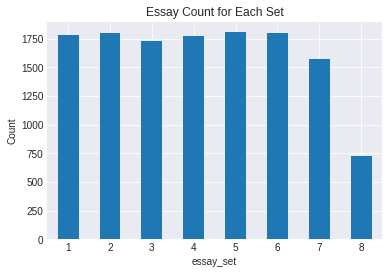

In [0]:
# look at number of essays for each set
train_df.groupby(['essay_set']).agg('count').plot.bar(y='essay', rot=0, legend=False)
plt.ylabel('Count')
plt.title('Essay Count for Each Set')
plt.show()

In [0]:
# get info on overall score range
train_df[['rater1_domain1', 'rater2_domain1', 'target_score']].describe().round(2)

,rater1_domain1,rater2_domain1,target_score
count,12976.00,12976.00,12976.00
mean,4.13,4.14,6.80
std,4.21,4.26,8.97
min,0.00,0.00,0.00
25%,2.00,2.00,2.00
50%,3.00,3.00,3.00
75%,4.00,4.00,8.00
max,30.00,30.00,60.00


In [0]:
# look into score info for each essay set
train_df.groupby(['essay_set'])['target_score'].agg(['min', 'max', 'count', 'nunique'])

,min,max,count,nunique
essay_set,,,,
1,2,12,1783,11
2,1,6,1800,6
3,0,3,1726,4
4,0,3,1770,4
5,0,4,1805,5
6,0,4,1800,5
7,2,24,1569,23
8,10,60,723,34


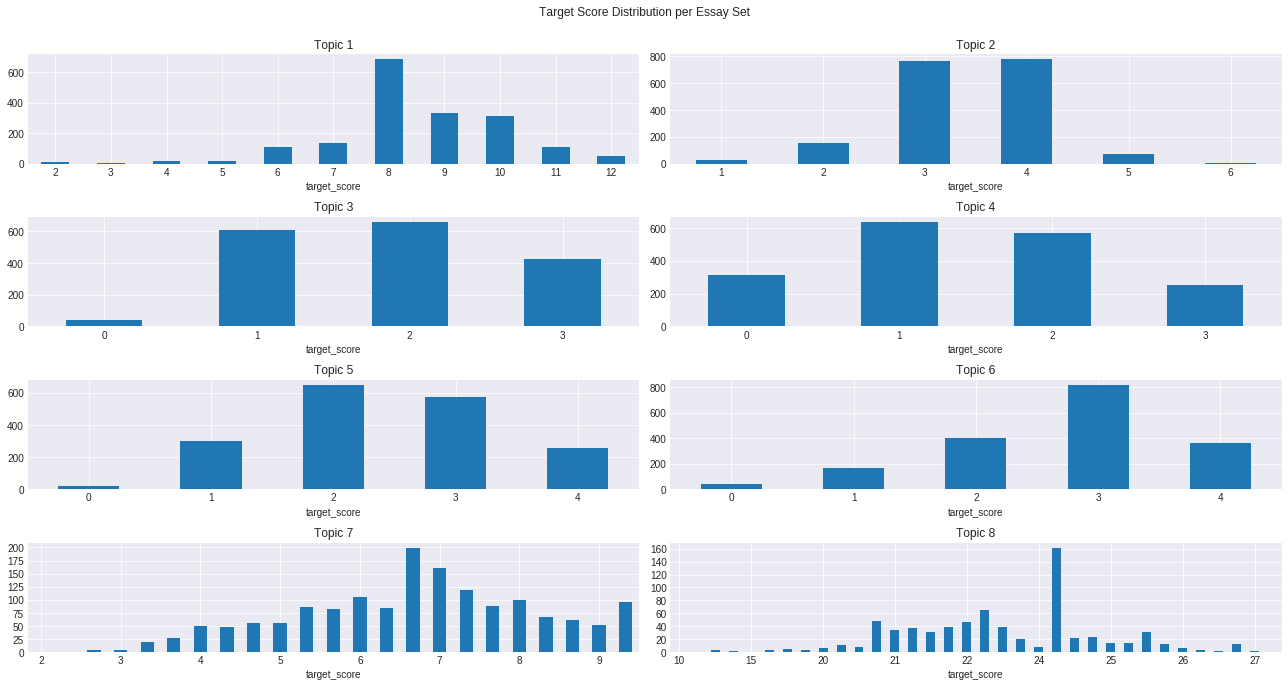

In [0]:
# plot distribution of target scores for each essay set
topic_number = 0
fig, ax = plt.subplots(4, 2, figsize=(18, 10), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        train_df[train_df['essay_set'] == topic_number].groupby('target_score')['essay_set'].agg('count').plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic ' + str(topic_number))
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Target Score Distribution per Essay Set')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [0]:
# look at word_count and sentence_count for essays
train_df['word_count'] = train_df['essay'].str.strip().str.split().str.len()
train_df['sentence_count'] = train_df['essay'].str.strip().str.split('.').str.len()
train_df.groupby(['essay_set'])['word_count', 'sentence_count'].agg(['min', 'max', 'mean']).T.round(2)

essay_set                 1        2       3  ...       6       7       8
word_count     min     8.00    31.00   10.00  ...    3.00    5.00    4.00
               max   785.00  1064.00  375.00  ...  454.00  592.00  856.00
               mean  365.68   380.75  108.69  ...  153.30  168.20  604.87
sentence_count min     1.00     1.00    1.00  ...    1.00    1.00    1.00
               max    54.00   643.00   23.00  ...   33.00   53.00   89.00
               mean   22.15    20.62    7.33  ...    9.53   11.86   34.98

[6 rows x 8 columns]

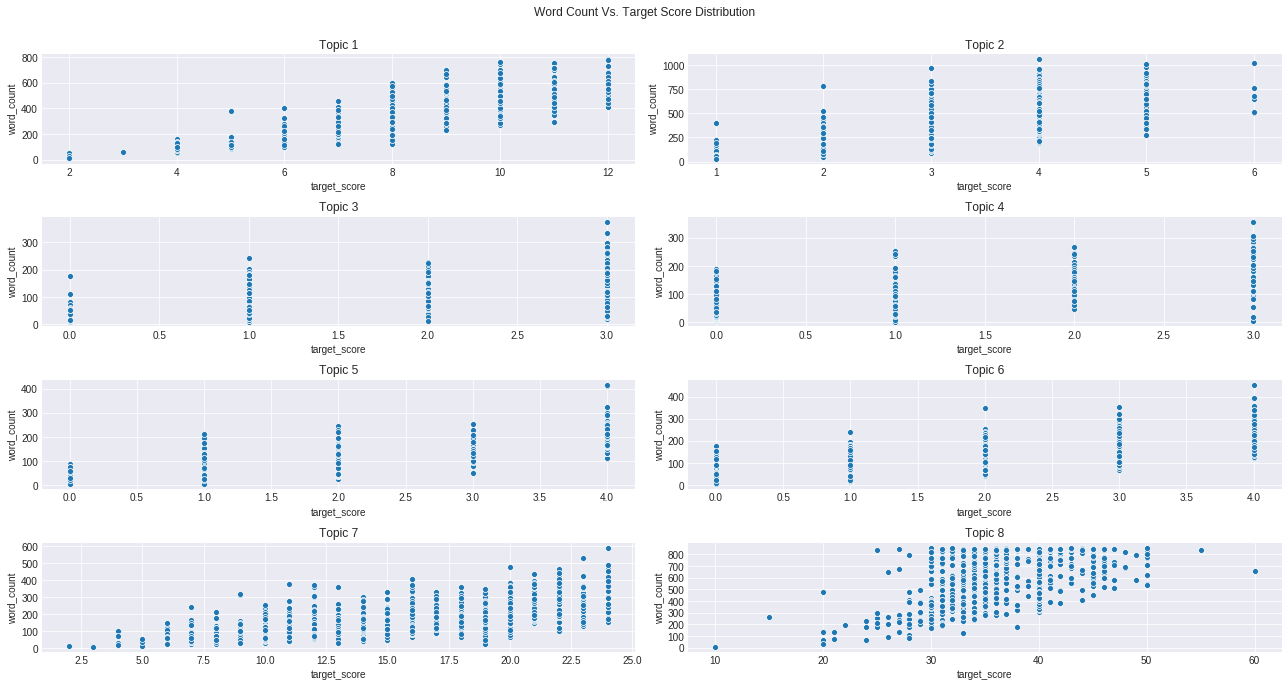

In [0]:
# plot distribution of word count vs target score
topic_number = 0
fig, ax = plt.subplots(4, 2, figsize=(18,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.scatterplot(x='target_score', y='word_count', data=train_df[train_df['essay_set'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic ' + str(topic_number))
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Word Count Vs. Target Score Distribution')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


			Topic 1


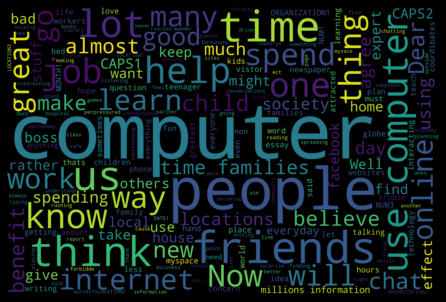


			Topic 2


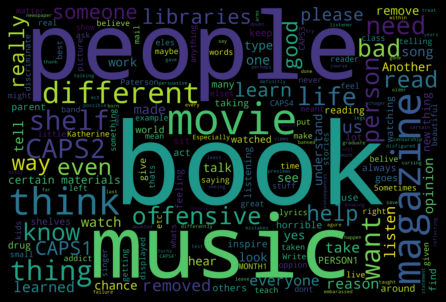


			Topic 3


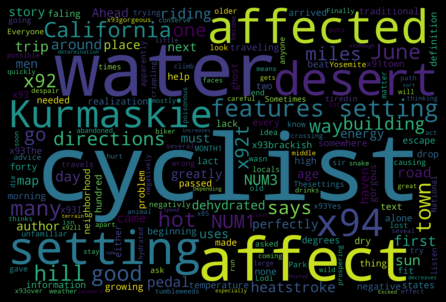


			Topic 4


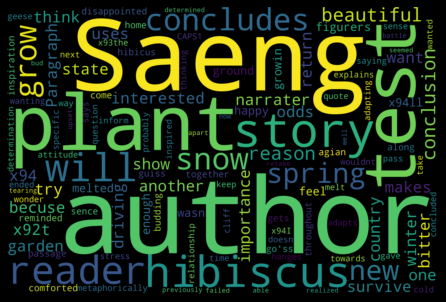


			Topic 5


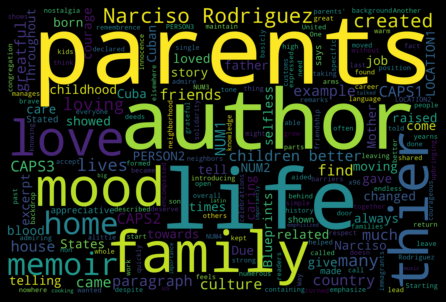


			Topic 6


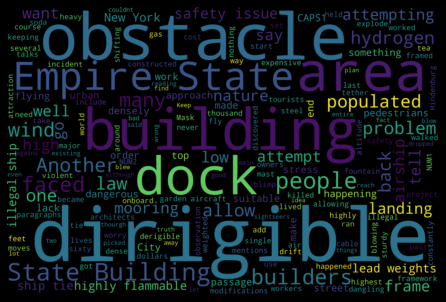


			Topic 7


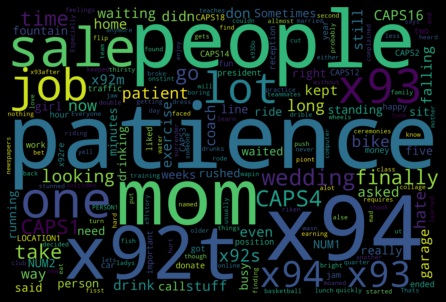


			Topic 8


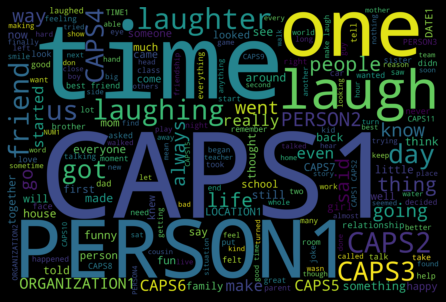

In [0]:
# plot wordcloud for each essay topic
for i in range(1, 9):
    print('\n\t\t\tTopic ' + str(i))
    wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'black', 
                          stopwords = STOPWORDS).generate(str(train_df[train_df['essay_set'] == i].essay.values))
    fig = plt.figure(facecolor = 'k', edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

# Data Cleaning

In [0]:
# replace Named Entity Recognition @TAGS with better labels
# replace \x92 with ', \x93 with ", \x94 with "
# remove stopwords if specified
def cleanEssay(text, removeSW):
    ner_list = ['caps', 'city', 'date', 'dr', 'location', 'money', 'month', 
                'num', 'organization', 'percent', 'person', 'state', 'time', 'email']
    for ner in ner_list:
        pattern = re.compile(r'@' + ner + '\d{0,2}', re.I) # ignore case while parsing
        text = pattern.sub('label_' + ner, text)
    text = text.lower()
    text = text.replace('\x92', '\'').replace('\x93', '\"').replace('\x94', '\"')
    if removeSW:
        sw_list = nltk.corpus.stopwords.words('english')
        text = ' '.join([word for word in text.split() if word not in sw_list])
    return text

In [0]:
# tokenizes essay into single list of words
# removes punctuations from each word
def tokenizeEssay(essay):
    tokens = nltk.word_tokenize(essay)
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [w for w in tokens if w.isalpha()]
    '''sentences = nltk.sent_tokenize(essay)
    tokens = []
    for sent in sentences:
        sent_tokens = nltk.word_tokenize(sent)
        table = str.maketrans('', '', string.punctuation)
        sent_tokens = [w.translate(table) for w in sent_tokens]
        sent_tokens = [w for w in sent_tokens if w.isalpha()]
        tokens.append(sent_tokens)'''
    return tokens

In [0]:
train_df['essay_clean_noSW'] = train_df['essay'].apply(cleanEssay, removeSW=True)
train_df['essay_clean_SW'] = train_df['essay'].apply(cleanEssay, removeSW=False)
train_df['essay_tokenized_noSW'] = train_df['essay_clean_noSW'].apply(tokenizeEssay)
train_df['essay_tokenized_SW'] = train_df['essay_clean_SW'].apply(tokenizeEssay)
train_df.head(10)

,essay_set,essay,rater1_domain1,rater2_domain1,target_score,essay_clean_noSW,essay_clean_SW,essay_tokenized_noSW,essay_tokenized_SW
0,1,"Dear local newspaper, I think effects computer...",4,4,8,"dear local newspaper, think effects computers ...","dear local newspaper, i think effects computer...","[dear, local, newspaper, think, effects, compu...","[dear, local, newspaper, i, think, effects, co..."
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9,"dear label_caps label_caps, believe using comp...","dear label_caps label_caps, i believe that usi...","[dear, labelcaps, labelcaps, believe, using, c...","[dear, labelcaps, labelcaps, i, believe, that,..."
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7,"dear, label_caps label_caps label_caps people ...","dear, label_caps label_caps label_caps more an...","[dear, labelcaps, labelcaps, labelcaps, people...","[dear, labelcaps, labelcaps, labelcaps, more, ..."
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10,"dear local newspaper, label_caps found many ex...","dear local newspaper, label_caps i have found ...","[dear, local, newspaper, labelcaps, found, man...","[dear, local, newspaper, labelcaps, i, have, f..."
4,1,"Dear @LOCATION1, I know having computers has a...",4,4,8,"dear label_location, know computers positive e...","dear label_location, i know having computers h...","[dear, labellocation, know, computers, positiv...","[dear, labellocation, i, know, having, compute..."
5,1,"Dear @LOCATION1, I think that computers have a...",4,4,8,"dear label_location, think computers negative ...","dear label_location, i think that computers ha...","[dear, labellocation, think, computers, negati...","[dear, labellocation, i, think, that, computer..."
6,1,Did you know that more and more people these d...,5,5,10,"know people days depending computers safety, n...",did you know that more and more people these d...,"[know, people, days, depending, computers, saf...","[did, you, know, that, more, and, more, people..."
7,1,@PERCENT1 of people agree that computers make ...,5,5,10,label_percent people agree computers make life...,label_percent of people agree that computers m...,"[labelpercent, people, agree, computers, make,...","[labelpercent, of, people, agree, that, comput..."
8,1,"Dear reader, @ORGANIZATION1 has had a dramatic...",4,5,9,"dear reader, label_organization dramatic effec...","dear reader, label_organization has had a dram...","[dear, reader, labelorganization, dramatic, ef...","[dear, reader, labelorganization, has, had, a,..."
9,1,In the @LOCATION1 we have the technology of a ...,5,4,9,label_location technology computer. say comput...,in the label_location we have the technology o...,"[labellocation, technology, computer, say, com...","[in, the, labellocation, we, have, the, techno..."



			Topic 1


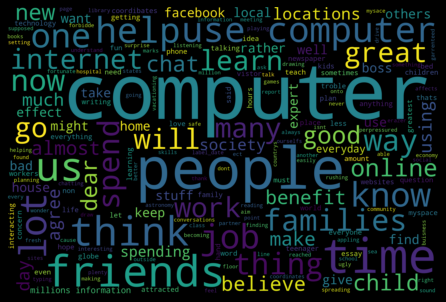


			Topic 2


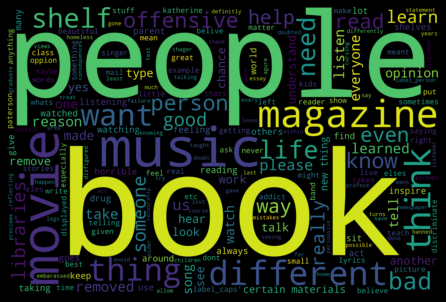


			Topic 3


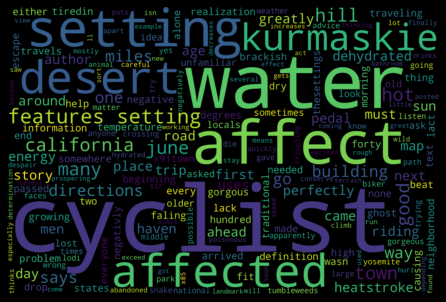


			Topic 4


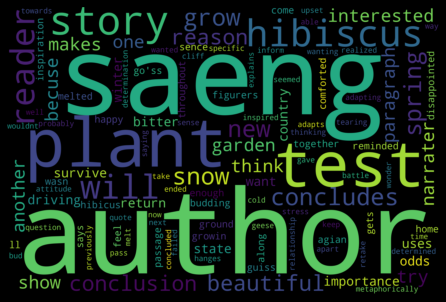


			Topic 5


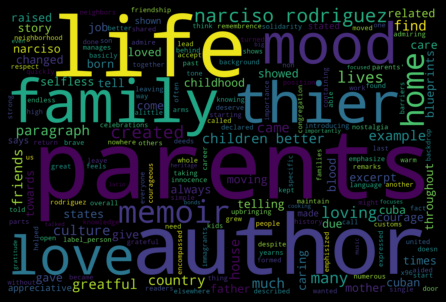


			Topic 6


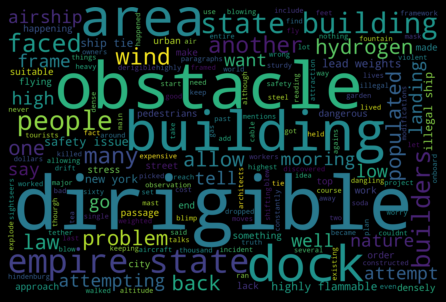


			Topic 7


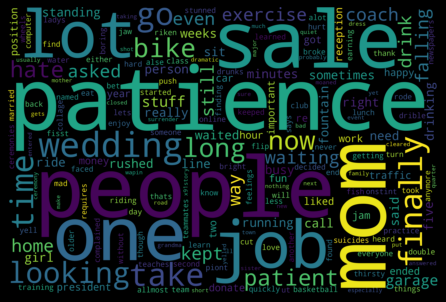


			Topic 8


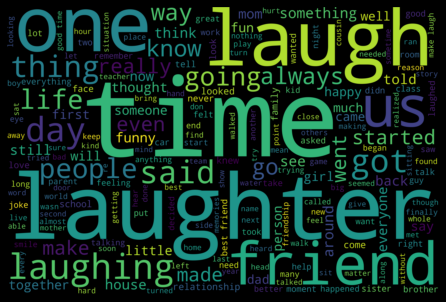

In [0]:
# plot wordcloud for each essay topic
wordcloud_sw_list = list(STOPWORDS) + ['label_' + i for i in ['caps', 'city', 'date', 'dr', 'location', 'money', 'month', 
                                                              'num', 'organization', 'percent', 'person', 'state', 'time', 'email']]
for i in range(1, 9):
    print('\n\t\t\tTopic ' + str(i))
    wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'black', 
                          stopwords = wordcloud_sw_list).generate(str(train_df[train_df['essay_set'] == i].essay_clean_SW.values))
    fig = plt.figure(facecolor = 'k', edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [0]:
# store cleaned train_df as csv file
train_df.to_csv('./DATA/clean_train.csv', index=False)

## Clean Essay of Validation and Test set as well to be used later for word2vec training

In [0]:
val_df = pd.read_csv('./DATA/valid_set.tsv', sep='\t', encoding='ISO-8859-1')
print('Shape of Val:', val_df.shape)
val_df.head()

Shape of Val: (4218, 5)


,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,1788,1,"Dear @ORGANIZATION1, @CAPS1 more and more peop...",1788,NaN
1,1789,1,Dear @LOCATION1 Time @CAPS1 me tell you what I...,1789,NaN
2,1790,1,"Dear Local newspaper, Have you been spending a...",1790,NaN
3,1791,1,"Dear Readers, @CAPS1 you imagine how life woul...",1791,NaN
4,1792,1,"Dear newspaper, I strongly believe that comput...",1792,NaN


In [0]:
val_df['essay_clean_noSW'] = val_df['essay'].apply(cleanEssay, removeSW=True)
val_df['essay_clean_SW'] = val_df['essay'].apply(cleanEssay, removeSW=False)
val_df['essay_tokenized_noSW'] = val_df['essay_clean_noSW'].apply(tokenizeEssay)
val_df['essay_tokenized_SW'] = val_df['essay_clean_SW'].apply(tokenizeEssay)
val_df.head(10)

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid,essay_clean_noSW,essay_clean_SW,essay_tokenized_noSW,essay_tokenized_SW
0,1788,1,"Dear @ORGANIZATION1, @CAPS1 more and more peop...",1788,NaN,"dear label_organization, label_caps people sta...","dear label_organization, label_caps more and m...","[dear, labelorganization, labelcaps, people, s...","[dear, labelorganization, labelcaps, more, and..."
1,1789,1,Dear @LOCATION1 Time @CAPS1 me tell you what I...,1789,NaN,dear label_location time label_caps tell think...,dear label_location time label_caps me tell yo...,"[dear, labellocation, time, labelcaps, tell, t...","[dear, labellocation, time, labelcaps, me, tel..."
2,1790,1,"Dear Local newspaper, Have you been spending a...",1790,NaN,"dear local newspaper, spending good portion ti...","dear local newspaper, have you been spending a...","[dear, local, newspaper, spending, good, porti...","[dear, local, newspaper, have, you, been, spen..."
3,1791,1,"Dear Readers, @CAPS1 you imagine how life woul...",1791,NaN,"dear readers, label_caps imagine life would st...","dear readers, label_caps you imagine how life ...","[dear, readers, labelcaps, imagine, life, woul...","[dear, readers, labelcaps, you, imagine, how, ..."
4,1792,1,"Dear newspaper, I strongly believe that comput...",1792,NaN,"dear newspaper, strongly believe computers pos...","dear newspaper, i strongly believe that comput...","[dear, newspaper, strongly, believe, computers...","[dear, newspaper, i, strongly, believe, that, ..."
5,1793,1,"Dear local newspaper, @CAPS1 the caveman found...",1793,NaN,"dear local newspaper, label_caps caveman found...","dear local newspaper, label_caps the caveman f...","[dear, local, newspaper, labelcaps, caveman, f...","[dear, local, newspaper, labelcaps, the, cavem..."
6,1794,1,"Dear newspaper editor, @CAPS1 now is a letter ...",1794,NaN,"dear newspaper editor, label_caps letter expla...","dear newspaper editor, label_caps now is a let...","[dear, newspaper, editor, labelcaps, letter, e...","[dear, newspaper, editor, labelcaps, now, is, ..."
7,1795,1,"Dear @ORGANIZATION1, @CAPS1, there has been so...",1795,NaN,"dear label_organization, label_caps, talk comp...","dear label_organization, label_caps, there has...","[dear, labelorganization, labelcaps, talk, com...","[dear, labelorganization, labelcaps, there, ha..."
8,1796,1,"Dear Local Newspaper, I would like to complain...",1796,NaN,"dear local newspaper, would like complain ever...","dear local newspaper, i would like to complain...","[dear, local, newspaper, would, like, complain...","[dear, local, newspaper, i, would, like, to, c..."
9,1797,1,"Dear Newspaper, @CAPS1 having kids wasting the...",1797,NaN,"dear newspaper, label_caps kids wasting whole ...","dear newspaper, label_caps having kids wasting...","[dear, newspaper, labelcaps, kids, wasting, wh...","[dear, newspaper, labelcaps, having, kids, was..."


In [0]:
# store cleaned val_df as csv file
val_df.to_csv('./DATA/clean_val.csv', index=False)

In [0]:
test_df = pd.read_csv('./DATA/test_set.tsv', sep='\t', encoding='ISO-8859-1')
print('Shape of Test:', test_df.shape)
test_df.head()

Shape of Test: (4254, 5)


,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,2383,1,I believe that computers have a positive effec...,2383,NaN
1,2384,1,"Dear @CAPS1, I know some problems have came up...",2384,NaN
2,2385,1,"Dear to whom it @MONTH1 concern, Computers are...",2385,NaN
3,2386,1,"Dear @CAPS1 @CAPS2, @CAPS3 has come to my atte...",2386,NaN
4,2387,1,"Dear Local newspaper, I think that people have...",2387,NaN


In [0]:
test_df['essay_clean_noSW'] = test_df['essay'].apply(cleanEssay, removeSW=True)
test_df['essay_clean_SW'] = test_df['essay'].apply(cleanEssay, removeSW=False)
test_df['essay_tokenized_noSW'] = test_df['essay_clean_noSW'].apply(tokenizeEssay)
test_df['essay_tokenized_SW'] = test_df['essay_clean_SW'].apply(tokenizeEssay)
test_df.head(10)

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid,essay_clean_noSW,essay_clean_SW,essay_tokenized_noSW,essay_tokenized_SW
0,2383,1,I believe that computers have a positive effec...,2383,NaN,believe computers positive effect people. help...,i believe that computers have a positive effec...,"[believe, computers, positive, effect, people,...","[i, believe, that, computers, have, a, positiv..."
1,2384,1,"Dear @CAPS1, I know some problems have came up...",2384,NaN,"dear label_caps, know problems came individual...","dear label_caps, i know some problems have cam...","[dear, labelcaps, know, problems, came, indivi...","[dear, labelcaps, i, know, some, problems, hav..."
2,2385,1,"Dear to whom it @MONTH1 concern, Computers are...",2385,NaN,"dear label_month concern, computers reason peo...","dear to whom it label_month concern, computers...","[dear, labelmonth, concern, computers, reason,...","[dear, to, whom, it, labelmonth, concern, comp..."
3,2386,1,"Dear @CAPS1 @CAPS2, @CAPS3 has come to my atte...",2386,NaN,"dear label_caps label_caps, label_caps come at...","dear label_caps label_caps, label_caps has com...","[dear, labelcaps, labelcaps, labelcaps, come, ...","[dear, labelcaps, labelcaps, labelcaps, has, c..."
4,2387,1,"Dear Local newspaper, I think that people have...",2387,NaN,"dear local newspaper, think people lately spen...","dear local newspaper, i think that people have...","[dear, local, newspaper, think, people, lately...","[dear, local, newspaper, i, think, that, peopl..."
5,2388,1,"Dear @CAPS1, @CAPS2 is in my firm belief that ...",2388,NaN,"dear label_caps, label_caps firm belief many p...","dear label_caps, label_caps is in my firm beli...","[dear, labelcaps, labelcaps, firm, belief, man...","[dear, labelcaps, labelcaps, is, in, my, firm,..."
6,2389,1,"Dear local newspaper, @CAPS1 your computer hav...",2389,NaN,"dear local newspaper, label_caps computer addi...","dear local newspaper, label_caps your computer...","[dear, local, newspaper, labelcaps, computer, ...","[dear, local, newspaper, labelcaps, your, comp..."
7,2390,1,"Dear @CAPS1, I agreed with the people that fee...",2390,NaN,"dear label_caps, agreed people feel people spe...","dear label_caps, i agreed with the people that...","[dear, labelcaps, agreed, people, feel, people...","[dear, labelcaps, i, agreed, with, the, people..."
8,2391,1,"Dear @CAPS1 @CAPS2, I do not believe that comp...",2391,NaN,"dear label_caps label_caps, believe computers ...","dear label_caps label_caps, i do not believe t...","[dear, labelcaps, labelcaps, believe, computer...","[dear, labelcaps, labelcaps, i, do, not, belie..."
9,2392,1,Imagine that you walk into a friends home and ...,2392,NaN,imagine walk friends home home actually dirty....,imagine that you walk into a friends home and ...,"[imagine, walk, friends, home, home, actually,...","[imagine, that, you, walk, into, a, friends, h..."


In [0]:
# store cleaned test_df as csv file
test_df.to_csv('./DATA/clean_test.csv', index=False)

# Train Word2Vec on Train + Val + Test together -- save models

In [0]:
def saveWord2VecModel(essay_list, dim, filename):
    start = time.time()
    print('Training Word2Vec Model...')
    model = Word2Vec(essay_list, size=dim, window=5, min_count=1, sg=1) # sg=1 -- use skip-gram instead of CBOW
    print('Created Word2Vec Model in', np.round(time.time() - start, 2), 'seconds')
    print(len(model.wv.vocab), 'uniques words represented by', dim, 'dimensional vectors')
    model.save(filename)
    print('Saved Word2Vec Model')

In [0]:
# load train, val, test essays and train word2vec models
df1 = pd.read_csv('./DATA/clean_train.csv', index_col=False, usecols=['essay_tokenized_noSW', 'essay_tokenized_SW'])
df2 = pd.read_csv('./DATA/clean_val.csv', index_col=False, usecols=['essay_tokenized_noSW', 'essay_tokenized_SW'])
df3 = pd.read_csv('./DATA/clean_test.csv', index_col=False, usecols=['essay_tokenized_noSW', 'essay_tokenized_SW'])
df = pd.concat([df1, df2, df3])
print('Shape of Combined Dataframe:', df.shape)
# convert string column back to lists type
df[['essay_tokenized_noSW', 'essay_tokenized_SW']] = df[['essay_tokenized_noSW', 'essay_tokenized_SW']].applymap(literal_eval)
df.head(10)

Shape of Combined Dataframe: (21448, 2)


,essay_tokenized_noSW,essay_tokenized_SW
0,"[dear, local, newspaper, think, effects, compu...","[dear, local, newspaper, i, think, effects, co..."
1,"[dear, labelcaps, labelcaps, believe, using, c...","[dear, labelcaps, labelcaps, i, believe, that,..."
2,"[dear, labelcaps, labelcaps, labelcaps, people...","[dear, labelcaps, labelcaps, labelcaps, more, ..."
3,"[dear, local, newspaper, labelcaps, found, man...","[dear, local, newspaper, labelcaps, i, have, f..."
4,"[dear, labellocation, know, computers, positiv...","[dear, labellocation, i, know, having, compute..."
5,"[dear, labellocation, think, computers, negati...","[dear, labellocation, i, think, that, computer..."
6,"[know, people, days, depending, computers, saf...","[did, you, know, that, more, and, more, people..."
7,"[labelpercent, people, agree, computers, make,...","[labelpercent, of, people, agree, that, comput..."
8,"[dear, reader, labelorganization, dramatic, ef...","[dear, reader, labelorganization, has, had, a,..."
9,"[labellocation, technology, computer, say, com...","[in, the, labellocation, we, have, the, techno..."


In [0]:
noSW_list = df['essay_tokenized_noSW'].to_list()
SW_list = df['essay_tokenized_SW'].to_list()
print('Length of noSW List:', len(noSW_list))
print('Length of SW List:', len(SW_list))

Length of noSW List: 21448
Length of SW List: 21448


In [0]:
saveWord2VecModel(essay_list=noSW_list, dim=50, filename='50_noSW_word2vec_model')

Training Word2Vec Model...
Created Word2Vec Model in 64.89 seconds
55547 uniques words represented by 50 dimensional vectors


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Saved Word2Vec Model


In [0]:
saveWord2VecModel(essay_list=noSW_list, dim=100, filename='100_noSW_word2vec_model')

Training Word2Vec Model...
Created Word2Vec Model in 59.31 seconds
55547 uniques words represented by 100 dimensional vectors


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Saved Word2Vec Model


In [0]:
saveWord2VecModel(essay_list=noSW_list, dim=200, filename='200_noSW_word2vec_model')

Training Word2Vec Model...
Created Word2Vec Model in 74.11 seconds
55547 uniques words represented by 200 dimensional vectors
Saved Word2Vec Model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
saveWord2VecModel(essay_list=noSW_list, dim=300, filename='300_noSW_word2vec_model')

Training Word2Vec Model...
Created Word2Vec Model in 89.2 seconds
55547 uniques words represented by 300 dimensional vectors
Saved Word2Vec Model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
saveWord2VecModel(essay_list=noSW_list, dim=500, filename='500_noSW_word2vec_model')

Training Word2Vec Model...
Created Word2Vec Model in 122.89 seconds
55547 uniques words represented by 500 dimensional vectors
Saved Word2Vec Model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
saveWord2VecModel(essay_list=SW_list, dim=50, filename='50_SW_word2vec_model')

Training Word2Vec Model...
Created Word2Vec Model in 93.64 seconds
55548 uniques words represented by 50 dimensional vectors


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Saved Word2Vec Model


In [0]:
saveWord2VecModel(essay_list=SW_list, dim=100, filename='100_SW_word2vec_model')

Training Word2Vec Model...
Created Word2Vec Model in 83.21 seconds
55548 uniques words represented by 100 dimensional vectors


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Saved Word2Vec Model


In [0]:
saveWord2VecModel(essay_list=SW_list, dim=200, filename='200_SW_word2vec_model')

Training Word2Vec Model...
Created Word2Vec Model in 102.4 seconds
55548 uniques words represented by 200 dimensional vectors
Saved Word2Vec Model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
saveWord2VecModel(essay_list=SW_list, dim=300, filename='300_SW_word2vec_model')

Training Word2Vec Model...
Created Word2Vec Model in 130.45 seconds
55548 uniques words represented by 300 dimensional vectors
Saved Word2Vec Model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
saveWord2VecModel(essay_list=SW_list, dim=500, filename='500_SW_word2vec_model')

Training Word2Vec Model...
Created Word2Vec Model in 175.99 seconds
55548 uniques words represented by 500 dimensional vectors
Saved Word2Vec Model


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Analyze Word Embedding

In [15]:
sim_list = Word2Vec.load('./DATA/custom_word2vec_models/500_noSW_word2vec_model').wv.most_similar('computer')
pd.DataFrame(sim_list, columns=['Most Similar Word - computer', 'Cosine Similarity']).round(2)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,Most Similar Word - computer,Cosine Similarity
0,computers,0.80
1,internet,0.73
2,computor,0.70
3,compute,0.68
4,internent,0.67
5,laptops,0.66
6,peopel,0.66
7,electronic,0.66
8,comuter,0.66
9,web,0.66


In [16]:
sim_list = Word2Vec.load('./DATA/custom_word2vec_models/500_noSW_word2vec_model').wv.most_similar('laugh')
pd.DataFrame(sim_list, columns=['Most Similar Word - laugh', 'Cosine Similarity']).round(2)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,Most Similar Word - laugh,Cosine Similarity
0,laughing,0.76
1,laughs,0.76
2,joke,0.73
3,laughter,0.72
4,ache,0.71
5,goofy,0.70
6,giggle,0.70
7,chuckle,0.68
8,bust,0.68
9,obnoxious,0.68


In [20]:
sim_list = Word2Vec.load('./DATA/custom_word2vec_models/500_noSW_word2vec_model').wv.most_similar('cycle')
pd.DataFrame(sim_list, columns=['Most Similar Word - cycle', 'Cosine Similarity']).round(2)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,Most Similar Word - cycle,Cosine Similarity
0,cycles,0.87
1,pedaling,0.86
2,slowing,0.86
3,hilly,0.86
4,rocky,0.86
5,uneven,0.86
6,uphill,0.86
7,tiring,0.86
8,drained,0.85
9,downhill,0.83


In [0]:
# plots word vectors in 2D space
def plotWordVec(model, title, N):
    topNWords = model.wv.index2entity[:N] # get top N frequent words
    word_vectors = np.array([model.wv[w] for w in topNWords])
    twodim = PCA().fit_transform(word_vectors)[:, :2]
    df = pd.DataFrame({"x": [x for x in twodim[:, 0]], 
                       "y": [y for y in twodim[:, 1]], 
                       "words": topNWords})
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 10)
    p = sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", scatter_kws={"s": 30, "facecolors": ['red']})
    for i in range(0, df.shape[0]):
        p.text(df["x"][i], df["y"][i], '  ' + df["words"][i].title()).set_size(15)
    plt.title(title)
    plt.show()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


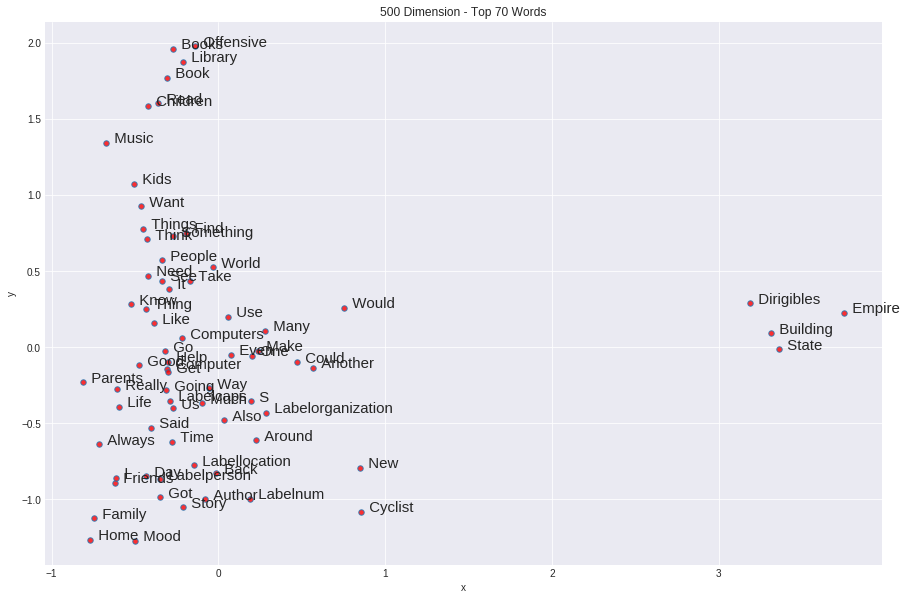

In [44]:
plotWordVec(Word2Vec.load('./DATA/custom_word2vec_models/500_noSW_word2vec_model'), 
            '500 Dimension - Top 70 Words', 70)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


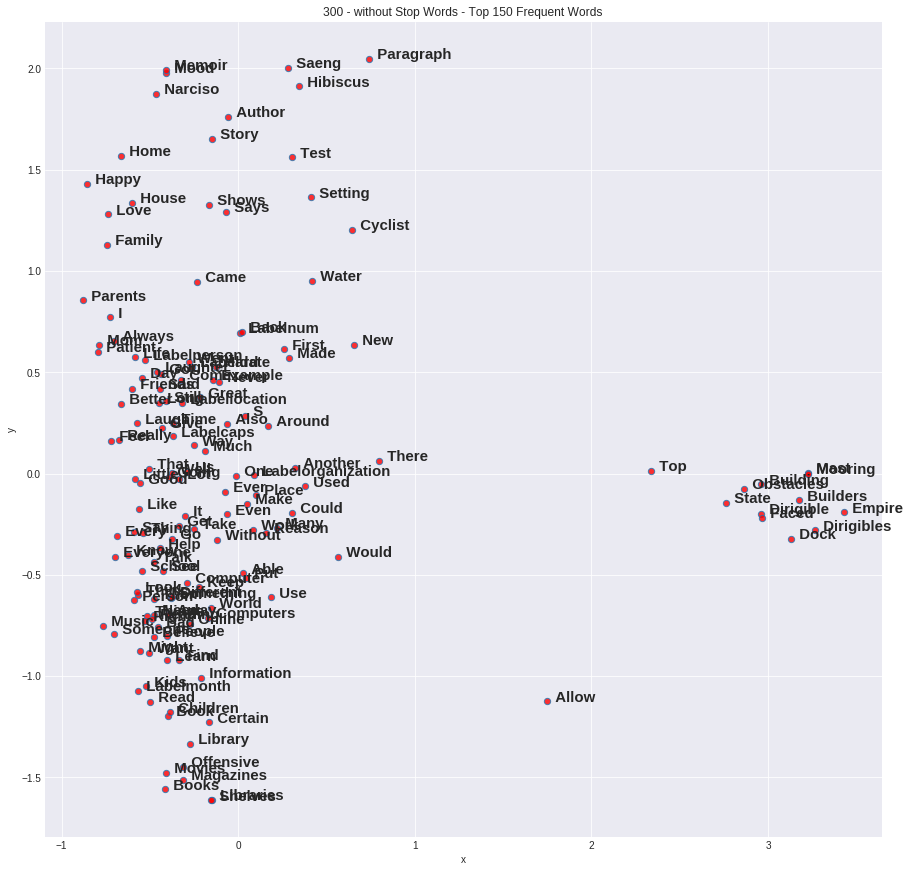

In [0]:
plotWordVec(Word2Vec.load('300_noSW_word2vec_model'), '300 - without Stop Words - Top 150 Frequent Words', 150)

# Analyze Cleaned Text

In [10]:
df = pd.read_csv('./DATA/clean_train.csv', index_col=False)
df.head()

,essay_set,essay,rater1_domain1,rater2_domain1,target_score,essay_clean_noSW,essay_clean_SW,essay_tokenized_noSW,essay_tokenized_SW
0,1,"Dear local newspaper, I think effects computer...",4,4,8,"dear local newspaper, think effects computers ...","dear local newspaper, i think effects computer...","['dear', 'local', 'newspaper', 'think', 'effec...","['dear', 'local', 'newspaper', 'i', 'think', '..."
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9,"dear label_caps label_caps, believe using comp...","dear label_caps label_caps, i believe that usi...","['dear', 'labelcaps', 'labelcaps', 'believe', ...","['dear', 'labelcaps', 'labelcaps', 'i', 'belie..."
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7,"dear, label_caps label_caps label_caps people ...","dear, label_caps label_caps label_caps more an...","['dear', 'labelcaps', 'labelcaps', 'labelcaps'...","['dear', 'labelcaps', 'labelcaps', 'labelcaps'..."
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10,"dear local newspaper, label_caps found many ex...","dear local newspaper, label_caps i have found ...","['dear', 'local', 'newspaper', 'labelcaps', 'f...","['dear', 'local', 'newspaper', 'labelcaps', 'i..."
4,1,"Dear @LOCATION1, I know having computers has a...",4,4,8,"dear label_location, know computers positive e...","dear label_location, i know having computers h...","['dear', 'labellocation', 'know', 'computers',...","['dear', 'labellocation', 'i', 'know', 'having..."


In [34]:
display(HTML('''<style>pre {white-space: normal;}</style>''')) # to disable horizontal scrolling
print(df.iloc[26].essay)

Computers a good because you can get infermation, you can play games, you can get pictures, But when you on the computer you might find something or someone that is bad or is viris. If ther is a vris you might want shut off the computers so it does not get worse. The are websites for kids, like games, there are teen games, there are adult games. Also pictures are bad for kids because most of the time they lead to inapropreit pictures. You should only look up infermation that you need not things like wepons or knifes. Also there are differnt kinds of companies like @CAPS1&t @CAPS2. @CAPS2 is a good place to get computers @CAPS1 so is @CAPS1&t.


In [39]:
display(HTML('''<style>pre {white-space: normal;}</style>''')) # to disable horizontal scrolling
print(df.iloc[26].essay_clean_noSW)

computers good get infermation, play games, get pictures, computer might find something someone bad viris. ther vris might want shut computers get worse. websites kids, like games, teen games, adult games. also pictures bad kids time lead inapropreit pictures. look infermation need things like wepons knifes. also differnt kinds companies like label_caps&t label_caps. label_caps good place get computers label_caps label_caps&t.


In [43]:
display(HTML('''<style>pre {white-space: normal;}</style>''')) # to disable horizontal scrolling
print(df.iloc[26].essay_tokenized_noSW)

['computers', 'good', 'get', 'infermation', 'play', 'games', 'get', 'pictures', 'computer', 'might', 'find', 'something', 'someone', 'bad', 'viris', 'ther', 'vris', 'might', 'want', 'shut', 'computers', 'get', 'worse', 'websites', 'kids', 'like', 'games', 'teen', 'games', 'adult', 'games', 'also', 'pictures', 'bad', 'kids', 'time', 'lead', 'inapropreit', 'pictures', 'look', 'infermation', 'need', 'things', 'like', 'wepons', 'knifes', 'also', 'differnt', 'kinds', 'companies', 'like', 'labelcaps', 't', 'labelcaps', 'labelcaps', 'good', 'place', 'get', 'computers', 'labelcaps', 'labelcaps', 't']
